# Summary of fragmentomics features in FinaleTools
This figure presents a precise summary of all of the fragmentomics features that can be calculated using the FinaleTools package and command line program.

### Features to Represent
- Fragment Coverage
- Fragment Lengths
- Window Protection Score (WPS)
- DNA evaluation of fragments for early interception (DELFI)
- End motifs
- Motif Diversity Score (MDS)

In [2]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import gzip

In [3]:
# Window Protection Score
ft_wps = []
with open("../data/BH01.chr12_asat.LWPS.raw.bedGraph", 'r') as ft_wps_file:
    for line in ft_wps_file:
        contents = line.split()
        ft_wps.append((contents[0], int(contents[1]), int(contents[2]), float(contents[3])))

shendure_wps = []
with gzip.open('../data/shendure.BH01.chr12.asat.wps.wig.gz', 'rt') as shendure_file:
    lines = shendure_file.readlines()
    header = lines[0].split()
    chrom = header[1].split('=')[1][3:]
    start = int(header[2].split('=')[1])
    step = int(header[3].split('=')[1])
    pos = start
    for line in lines[1:]:
        score = float(line)
        shendure_wps.append((chrom, pos, pos+1, score))
        pos += 1
ft_wps = np.array(ft_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
shendure_wps = np.array(shendure_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
ft_wps, shendure_wps

(array([('12', 34442000, 34442001, -24.), ('12', 34442001, 34442002, -24.),
        ('12', 34442002, 34442003, -26.), ...,
        ('12', 34446997, 34446998, -23.), ('12', 34446998, 34446999, -24.),
        ('12', 34446999, 34447000, -24.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]),
 array([('12', 34442000, 34442001, -52.), ('12', 34442001, 34442002, -49.),
        ('12', 34442002, 34442003, -51.), ...,
        ('12', 34446998, 34446999, -62.), ('12', 34446999, 34447000, -64.),
        ('12', 34447000, 34447001, -61.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]))

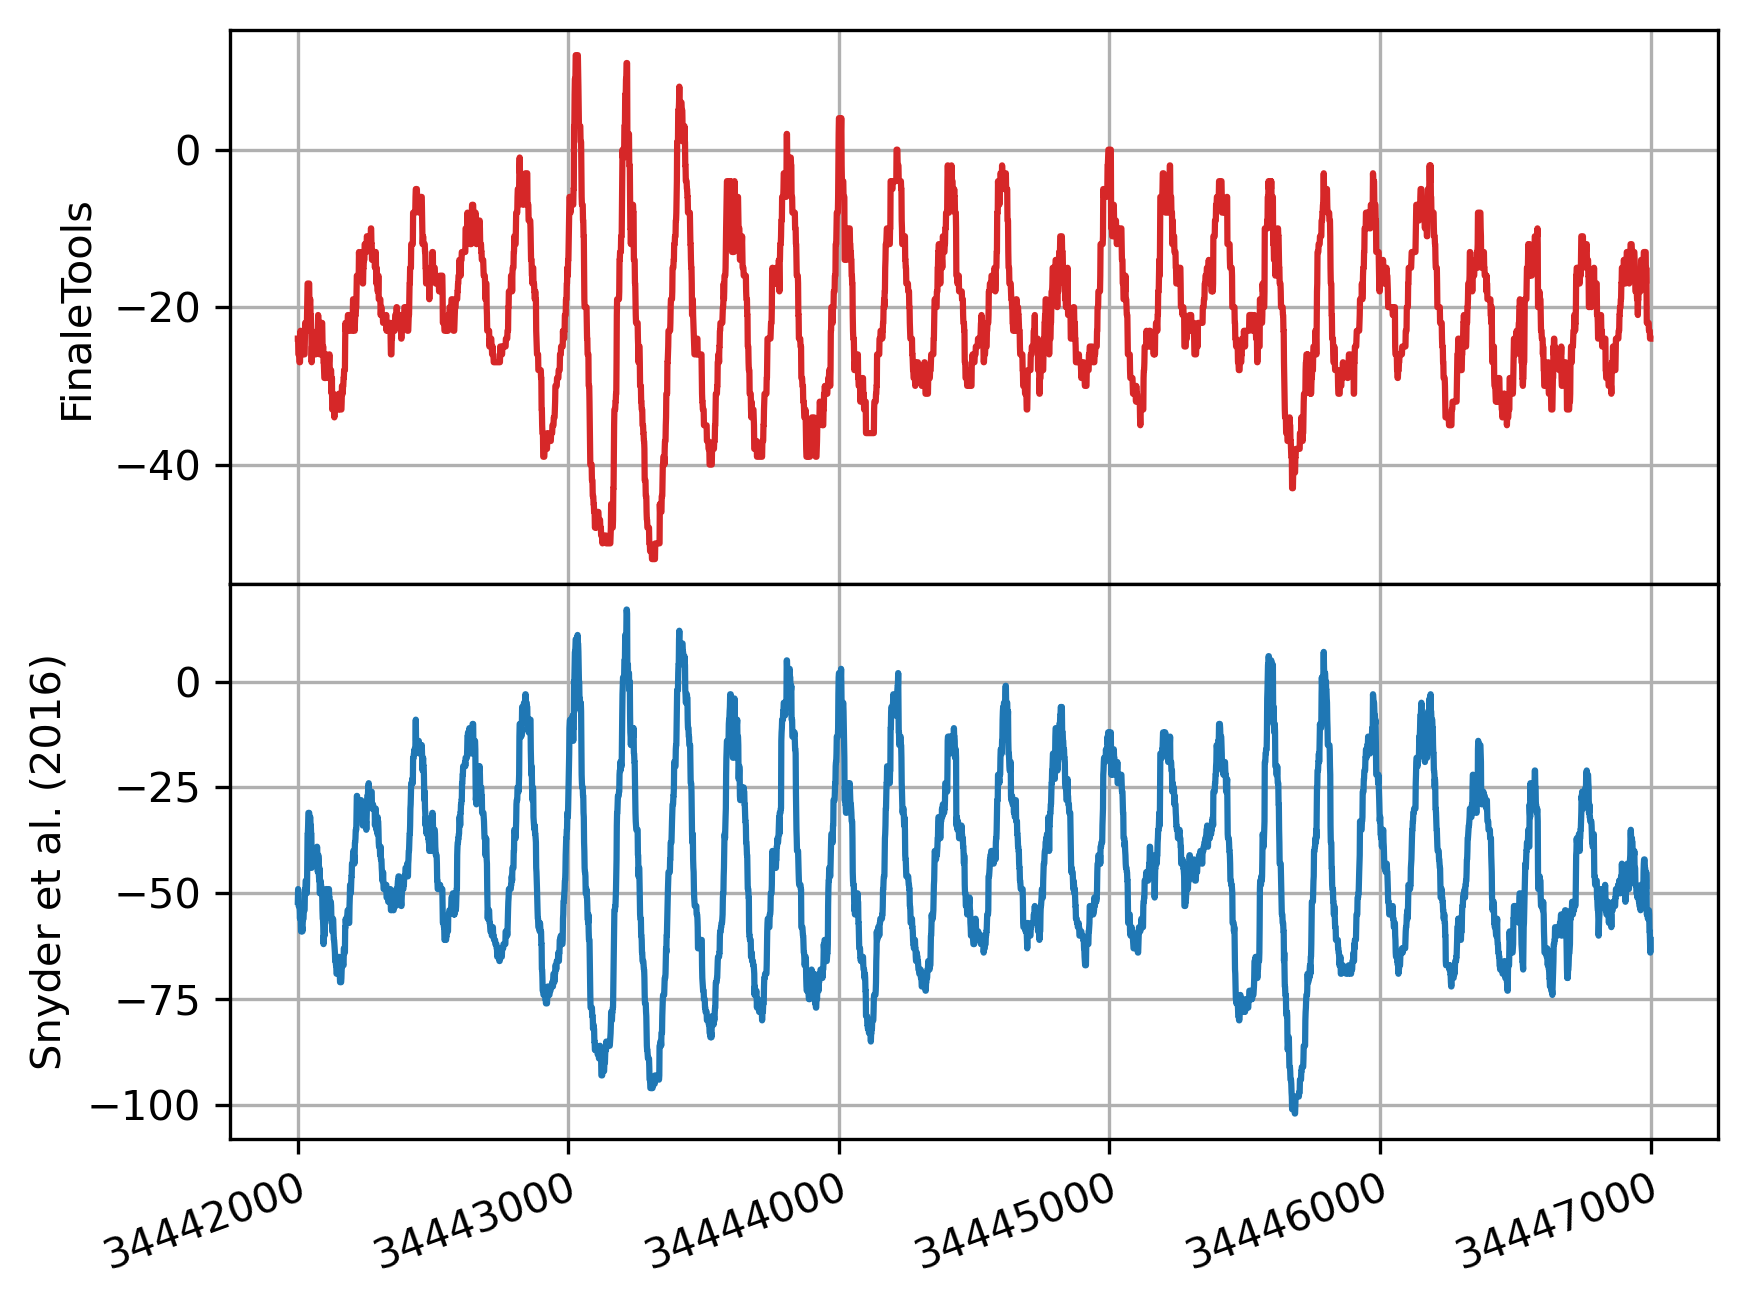

In [27]:
# plotting comparison
fig, axes = plt.subplots(2, 1, sharex=True)
fig.set_dpi(300)
axes[0].plot(ft_wps['start'], ft_wps['score'], c='C3')
axes[0].set_ylabel('FinaleTools')
axes[1].plot(shendure_wps['start'], shendure_wps['score'], c='C0')
axes[1].set_ylabel('Snyder et al. (2016)')

plt.setp(axes[1].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
x_formatter.set_scientific(False)
fig.subplots_adjust(hspace=0)
axes[1].xaxis.set_major_formatter(x_formatter)
axes[0].grid()
axes[1].grid()

for ax in axes:
    ax.label_outer()
